
数据和代码主要参考教程：https://blog.csdn.net/meng_shangjy/article/details/79714747 


#ARIMA建模的步骤。
#(1). 获取被观测系统时间序列数据；
#(2). 对数据绘图，观测是否为平稳时间序列；对于非平稳时间序列要先进行d阶差分运算，化为平稳时间序列；
#(3). 经过第二步处理，已经得到平稳时间序列。要对平稳时间序列分别求得其自相关系数ACF 和偏自相关系数PACF，通过对自相关图和偏自相关图的分析，得到最佳的阶层 p 和阶数 q
#(4). 由以上得到的d、q、p，得到ARIMA模型。然后开始对得到的模型进行模型检验。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams  #设置画布大小
rcParams['figure.figsize']=12,6

In [4]:
data=pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n dtypes')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 dtypes
Month          object
#Passengers     int64
dtype: object


In [12]:
dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m')
data = pd.read_csv('AirPassengers.csv',index_col='Month',date_parser=dateparse)  #加了date_parser=dateparse后，由于上面的labda函数，‘month’会变为含有年月日
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [42]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)
len(ts)

144

In [15]:
ts['1949-01-01']

112

In [18]:
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [21]:
ts[datetime(1949,1,1):datetime(1949,5,1)]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [22]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

作图，查看时间序列是否平稳性
Checking for stationarity
Plot the time-series

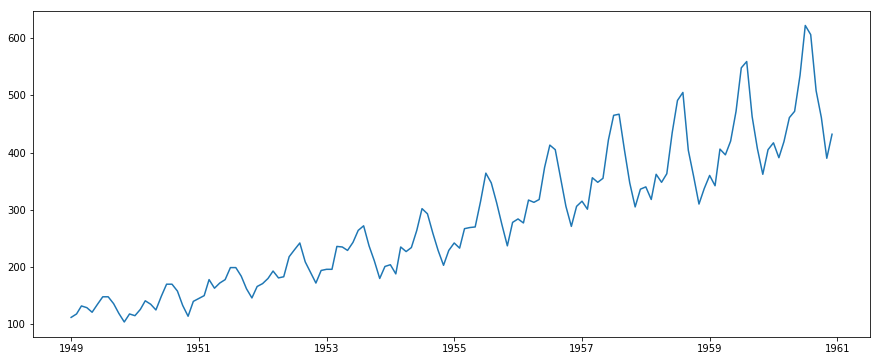

In [23]:
plt.plot(ts)

Function for testing stationarity

In [53]:
#4.检查时序数据的稳定性
#均值，方差，自方差如果与时间无关，则说明数据是稳定的
#python判断时序数据稳定性的两种方法
#Rolling statistic-- 即每个时间段内的平均的数据均值和标准差情况。
#Dickey-Fuller Test(迪基-福勒检验) -- 这个比较复杂，大致意思就是在一定置信水平下，对于时序数据假设 Null hypothesis: 非稳定。
#if 通过检验值(statistic)< 临界值(critical value)，则拒绝null hypothesis，即数据是稳定的；反之则是非稳定的。

from statsmodels.tsa.stattools import adfuller       #判断时序数据稳定性有两种方法，这是第二种方法
def test_stationarity(timeseries):
    
    #判断时间序列是否平稳的第一种方法，这里以一年为一个窗口，每一个时间t的值由它前面12个月（包括自己）的均值代替，标准差同理。
    rolmean = pd.rolling_mean(timeseries,window=12)
    rolstd = pd.rolling_std(timeseries,window=12)
    
    #plot rolling statistics
    orig = plt.plot(timeseries,color='blue',label='original')  #原始的时间序列图
    mean = plt.plot(rolmean,color='red',label='rolling mean')
    std = plt.plot(rolstd,color='black',label='rolling std')
    plt.legend(loc='left')
    plt.title('rolling mean & standard ')
    plt.show(block=False)    #由图可知，数据的rolling均值/标准差具有越来越大的趋势，是不稳定的。
    
    #判断时间序列是否平稳的第二种方法，即迪基-福勒检验
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    #dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print (dfoutput)  #由DF-test可以明确的指出，在任何置信度下，数据都不是稳定的。

    
    
    

D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  del sys.path[0]
D:\anaconda3_5_0\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


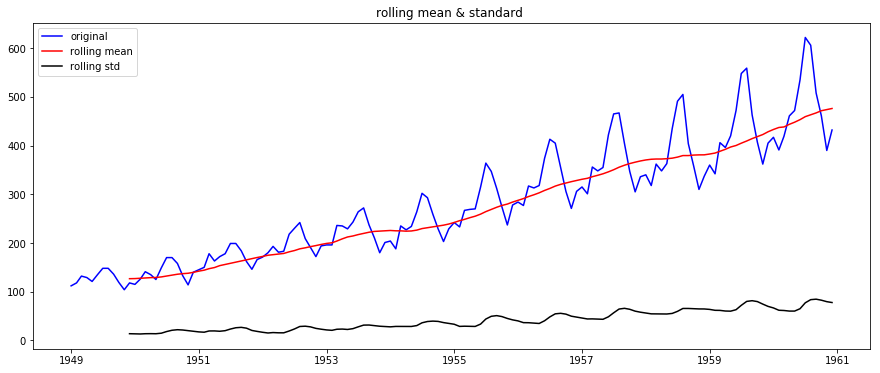

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [54]:
test_stationarity(ts)

让时间序列变得稳定

D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()


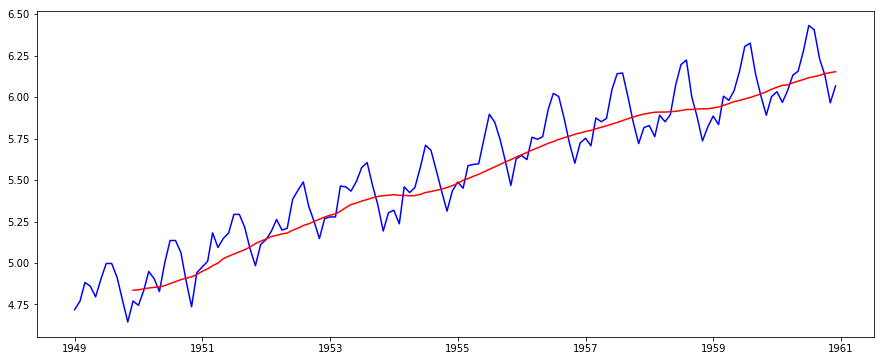

In [62]:
#============数据变不稳定的原因主要有俩：==================================================

#趋势（trend）-数据随着时间变化。比如说升高或者降低。
#季节性(seasonality)-数据在特定的时间段内变动。比如说节假日，或者活动导致数据的异常。
#由于原数据值域范围比较大，为了缩小值域，同时保留其他信息，常用的方法是对数化，取log。
#===========================================================================================
#===========================检测和去除趋势==================================================
#通常有三种方法：
#聚合 : 将时间轴缩短，以一段时间内星期/月/年的均值作为数据值。使不同时间段内的值差距缩小。
#平滑： 以一个滑动窗口内的均值代替原来的值，为了使值之间的差距缩小
#多项式过滤：用一个回归模型来拟合现有数据，使得数据更平滑。
#本文主要使用平滑方法
#============================================================================================

ts_log=np.log(ts)
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log,color='blue')
plt.plot(moving_avg,color='red')
#可以看出moving_average要比原值平滑许多。

#然后作差,注意ts_log和moving_avg都为series形式
ts_log_moving_avg_diff = ts_log-moving_avg  #取对数的减去取对数并平滑的
ts_log_moving_avg_diff.dropna(inplace=True)


D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  del sys.path[0]
D:\anaconda3_5_0\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


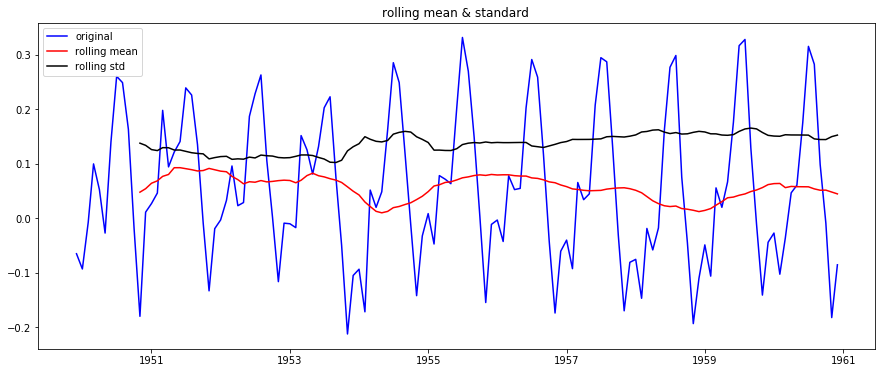

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [63]:
test_stationarity(ts_log_moving_avg_diff)    #蓝色为差值，红色为差值的均值，黑色为差值的标准差
#可以看到，做了处理之后的数据基本上没有了随时间变化的趋势，DFtest的结果告诉我们在95%的置信度下，数据是稳定的。

D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  del sys.path[0]
D:\anaconda3_5_0\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  s

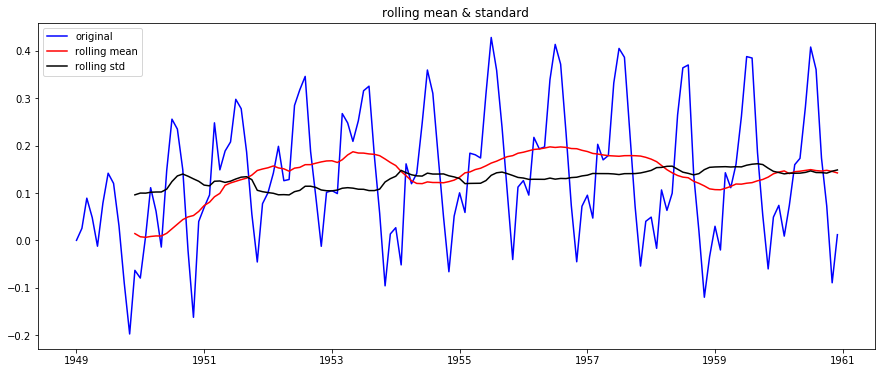

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [64]:
#上面的方法是将所有的时间平等看待，而在许多情况下，可以认为越近的时刻越重要。
#所以引入指数加权移动平均-- Exponentially-weighted moving average.（pandas中通过ewma()函数提供了此功能。）


# halflife的值决定了衰减因子alpha：  alpha = 1 - exp(log(0.5) / halflife)
expweighted_avg = pd.ewma(ts_log,halflife=12)
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

#可以看到相比普通的Moving Average，新的数据平均标准差更小了。而且DFtest可以得到结论：数据在99%的置信度上是稳定的。

In [65]:
#检测和去除季节性
#有两种方法：
#1 差分化： 以特定滞后数目的时刻的值 - 原时刻值
#2 分解： 对趋势和季节性分别建模在移除它们


In [74]:
ts_log_diff = ts_log.diff(1)
print(ts_log_diff.head())
print(ts_log.head())

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64
Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64


In [99]:
print(ts_log.head())
print((ts_log - ts_log.shift()).head())
print((ts_log.diff(1)).head())   #ts_log.diff(1)相当于ts_log - ts_log.shift()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64


D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  del sys.path[0]
D:\anaconda3_5_0\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


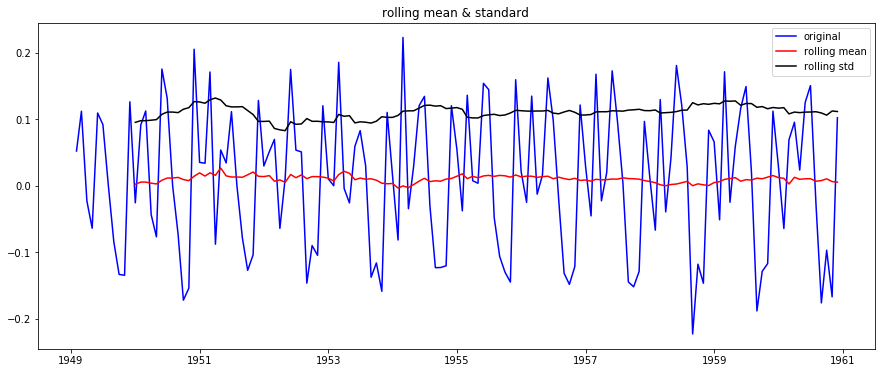

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [67]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
#如图，可以看出相比MA（moving average）方法，Differencing方法处理后的数据的均值和方差的在时间轴上的振幅明显缩小了。
#DFtest的结论是在90%的置信度下，数据是稳定的

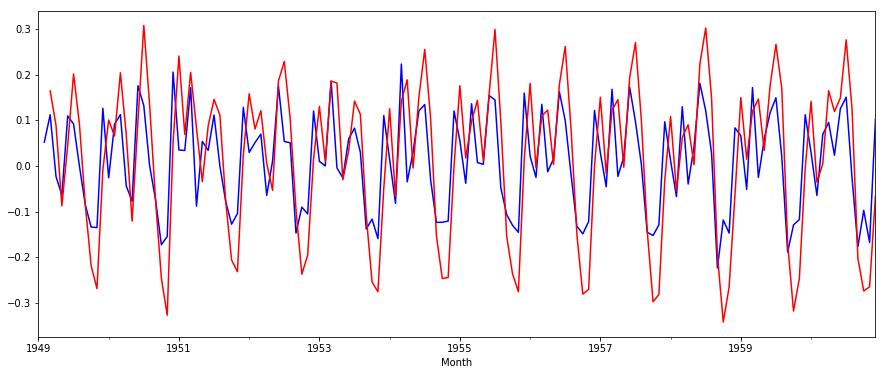

In [72]:
#上图看出一阶差分大致已经具有周期性，不妨绘制二阶差分对比：
#diff()函数是求导数和差分的
ts_log_diff1 = ts_log.diff(1)     #一阶差分
ts_log_diff2 = ts_log.diff(2)     #二阶差分
ts_log_diff1.plot(color='blue')
ts_log_diff2.plot(color='red')
plt.show()
#基本已经没有变化。所以使用一阶差分。


In [85]:
 #3.Decomposing-分解
#分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose    #分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来
def decompose(timeseries):
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend     # 趋势
    seasonal = decomposition.seasonal    # 季节性
    residual = decomposition.resid   # 剩余的
    plt.subplot(411)
    plt.plot(ts_log,label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual,label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual


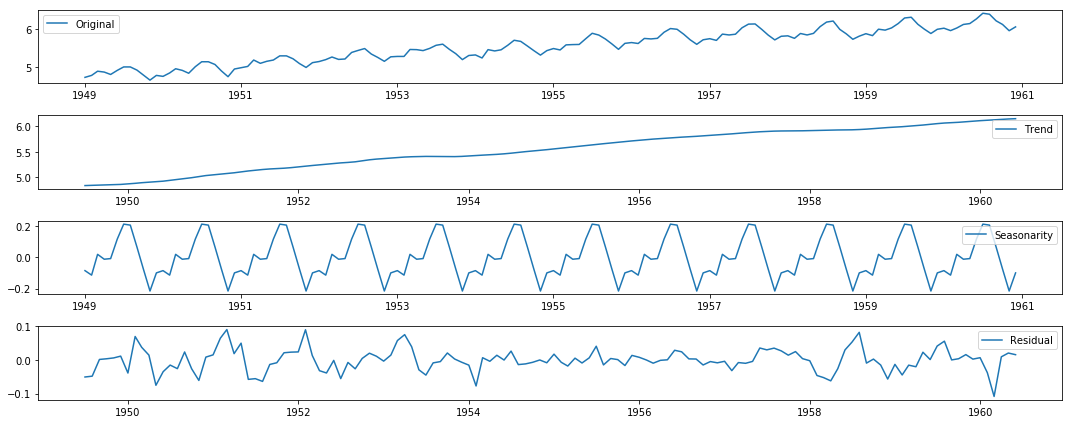

In [87]:
trend , seasonal, residual = decompose(ts_log)
#如图可以明显的看到，将original数据 拆分成了三份。Trend数据具有明显的趋势性，
#Seasonality数据具有明显的周期性，Residuals是剩余的部分，可以认为是去除了趋势和季节性数据之后，稳定的数据，是我们所需要的。

D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':
D:\anaconda3_5_0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  del sys.path[0]
D:\anaconda3_5_0\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


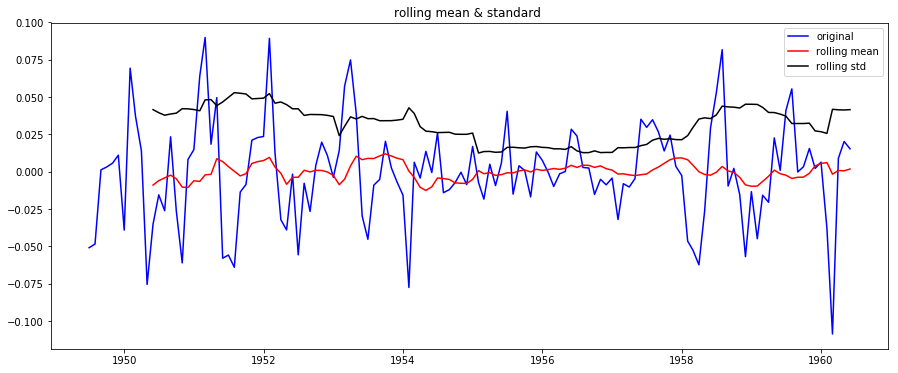

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical value (1%)           -3.485122e+00
Critical value (5%)           -2.885538e+00
Critical value (10%)          -2.579569e+00
dtype: float64


In [90]:
#消除了trend 和seasonal之后，只对residual部分作为想要的时序数据进行处理
residual.dropna(inplace=True)
test_stationarity(residual)


#如图所示，数据的均值和方差趋于常数，几乎无波动(看上去比之前的陡峭，但是要注意他的值域只有[-0.05,0.05]之间)，
#所以直观上可以认为是稳定的数据。另外DFtest的结果显示，Statistic值原小于1%时的Critical value，所以在99%的置信度下，数据是稳定的。


#6. 对时序数据进行预测

In [141]:
#假设经过处理，已经得到了稳定时序数据。接下来，我们使用ARIMA模型
#AR：自回归。一种模型，它使用观察与一些滞后观察之间的依赖关系。
#我：综合。使用原始观察的差分（例如，从前一时间步骤的观察中减去观察值）以使时间序列静止。
#MA：移动平均线。使用应用于滞后观察的移动平均模型中的观察和残差之间的依赖关系的模型。
#step1： 通过ACF,PACF进行ARIMA（p，d，q）的p，q参数估计
#p--代表预测模型中采用的时序数据本身的滞后数(lags) ,也叫做AR/Auto-Regressive项
#d--代表时序数据需要进行几阶差分化，才是稳定的，也叫Integrated项。
#q--代表预测模型中采用的预测误差的滞后数(lags)，也叫做MA/Moving Average项

#由前文Differencing差分部分已知，一阶差分后数据已经稳定，所以d=1。
#所以用一阶差分化的ts_log_diff = ts_log - ts_log.diff(1) 作为输入。
#等价于
#yt=Yt−Yt−1
#作为输入。


Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
1949-12-01    0.126294
1950-01-01   -0.025752
1950-02-01    0.091350
1950-03-01    0.112478
1950-04-01   -0.043485
1950-05-01   -0.076961
1950-06-01    0.175633
1950-07-01    0.131852
1950-08-01    0.000000
1950-09-01   -0.073203
1950-10-01   -0.172246
1950-11-01   -0.154151
1950-12-01    0.205444
1951-01-01    0.035091
1951-02-01    0.033902
1951-03-01    0.171148
1951-04-01   -0.088033
1951-05-01    0.053744
1951-06-01    0.034289
1951-07-01    0.111521
                ...   
1958-07-01    0.121098
1958-08-01    0.028114
1958-09-01   -0.223144
1958-10-01   -0.118092
1958-11-01   -0.146750
1958-12-01    0.083511
1959-01-01    0.066021
1959-02-01   -0.051293
1959-03-01    0.171542
1959-04-01   -0.024939
1959-05-01    0.058841
1959-06-01    0.116724
1959-

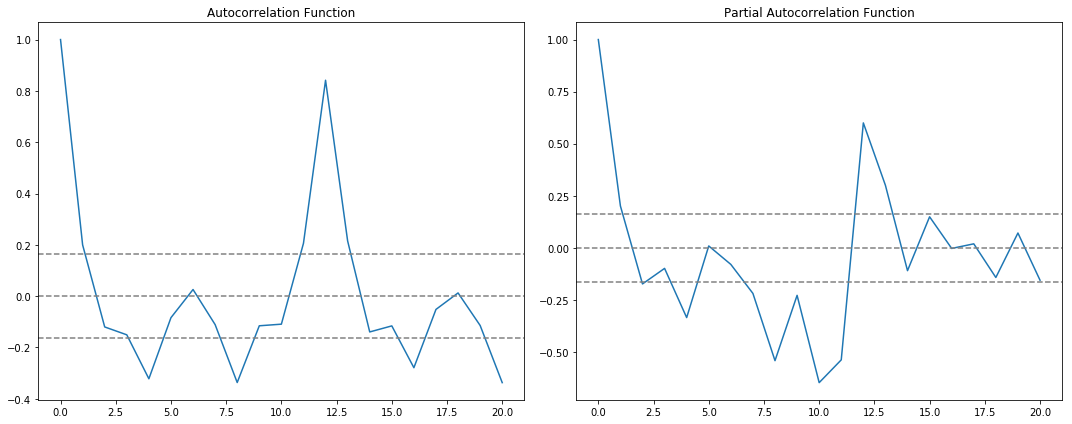

In [107]:
#因为要确定q和p值，所以先画出ACF和PACF
from statsmodels.tsa.stattools import acf,pacf
ts_log_diff.dropna(inplace=True)

lag_acf = acf(ts_log_diff,nlags=20)    #  注意 ts_log_diff 不能出现nan的值，否则lag_acf将全为nan nlags表示要计算acf的滞后数
print(ts_log_diff)
print(lag_acf)
lag_pacf = pacf(ts_log_diff,nlags=20,method='ols')   #  注意 ts_log_diff 不能出现nan的值，否则报错。 ols表示最小二乘法

#plog acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')  #置信区间。其中1.96为查表得知，若取95%的置信度，则a为0.05,0.5a为0.025，Z(0.025)=1.96，
                                                                              #https://wenku.baidu.com/view/a5698563783e0912a2162a42.html
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')    #置信区间
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

##图中，上下两条灰线之间是置信区间，p的值就是ACF第一次穿过上置信区间时的横轴值。q的值就是PACF第一次穿过上置信区间的横轴值。
#所以从图中可以得到p=2，q=2。

D:\anaconda3_5_0\lib\site-packages\scipy\signal\signaltools.py:1364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\anaconda3_5_0\lib\site-packages\scipy\signal\signaltools.py:1367: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\anaconda3_5_0\lib\site-packages\scipy\signal\signaltools.py:1373: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(s

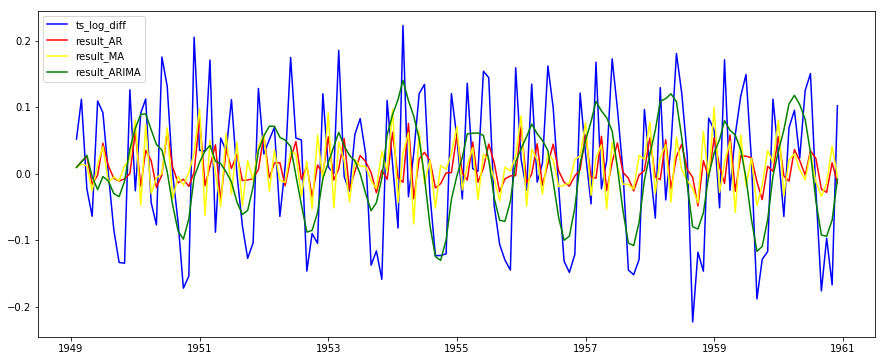

In [112]:
#step2： 得到参数估计值p，d，q之后，生成模型ARIMA（p，d，q）p=2   d=1   q=2
#为了突出差别，用三种参数取值的三个模型作为对比。
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(ts_log,order=(2,1,0))  #AR模型
model2 = ARIMA(ts_log,order=(0,1,2))   #MA模型
model3 = ARIMA(ts_log,order=(2,1,2))  #ARIMA模型

result_AR = model1.fit(disp=-1)
result_MA = model2.fit(disp=-1)
result_ARIMA = model3.fit(disp=-1)

plt.plot(ts_log_diff,color='blue',label='ts_log_diff')
plt.plot(result_AR.fittedvalues,color='red',label='result_AR')
plt.plot(result_MA.fittedvalues,color='yellow',label='result_MA')
plt.plot(result_ARIMA.fittedvalues,color='green',label='result_ARIMA')
plt.legend()
plt.show()
#由RSS，可知模型3--ARIMA（2,1,2）的拟合度最好，所以我们确定了最终的预测模型。注意，这里是要看拟合度，而不是mean之类的值



In [154]:
help(result_ARIMA.forecast)
'''
forecast(steps=1, exog=None, alpha=0.05) method of statsmodels.tsa.arima_model.ARIMAResults instance
    Out-of-sample forecasts
    
    Parameters
    ----------
    steps : int
        The number of out of sample forecasts from the end of the
        sample.
    exog : array
        If the model is an ARIMAX, you must provide out of sample
        values for the exogenous variables. This should not include
        the constant.
    alpha : float
        The confidence intervals for the forecasts are (1 - alpha) %
    
    Returns
    -------
    forecast : array
        Array of out of sample forecasts
    stderr : array
        Array of the standard error of the forecasts.
    conf_int : array
        2d array of the confidence interval for the forecast
    
    Notes
    -----
    Prediction is done in the levels of the original endogenous variable.
    If you would like prediction of differences in levels use `predict`.
    1、steps应该是需要预测时间序列往后多少个数据
    2、返回的值是3个数组，第一个数组为steps个预测值，第二个数组为第一个数组各个预测值的standard error，第三个数组应该是预测值（第一个数组）和
    standard error（第二个数组）的可信度
'''
output = result_ARIMA.forecast(10)
print(output)
print(output[0]) #预测值，共10个

Help on method forecast in module statsmodels.tsa.arima_model:

forecast(steps=1, exog=None, alpha=0.05) method of statsmodels.tsa.arima_model.ARIMAResults instance
    Out-of-sample forecasts
    
    Parameters
    ----------
    steps : int
        The number of out of sample forecasts from the end of the
        sample.
    exog : array
        If the model is an ARIMAX, you must provide out of sample
        values for the exogenous variables. This should not include
        the constant.
    alpha : float
        The confidence intervals for the forecasts are (1 - alpha) %
    
    Returns
    -------
    forecast : array
        Array of out of sample forecasts
    stderr : array
        Array of the standard error of the forecasts.
    conf_int : array
        2d array of the confidence interval for the forecast
    
    Notes
    -----
    Prediction is done in the levels of the original endogenous variable.
    If you would like prediction of differences in levels use `predic

In [115]:
print(result_ARIMA.fittedvalues)
#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个月与i-1个月的ts_log的差值。
#由于差分化有一阶滞后，所以第一个月的数据是空的，

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
1949-07-01   -0.004347
1949-08-01   -0.010978
1949-09-01   -0.029929
1949-10-01   -0.034467
1949-11-01   -0.011279
1949-12-01    0.037212
1950-01-01    0.068135
1950-02-01    0.089434
1950-03-01    0.090029
1950-04-01    0.066152
1950-05-01    0.044053
1950-06-01    0.035467
1950-07-01    0.003100
1950-08-01   -0.047127
1950-09-01   -0.086353
1950-10-01   -0.098465
1950-11-01   -0.067846
1950-12-01   -0.005227
1951-01-01    0.017385
1951-02-01    0.034016
1951-03-01    0.042561
1951-04-01    0.018748
1951-05-01    0.015260
1951-06-01    0.002489
1951-07-01   -0.012408
                ...   
1958-07-01    0.054477
1958-08-01   -0.016466
1958-09-01   -0.079842
1958-10-01   -0.083143
1958-11-01   -0.058869
1958-12-01   -0.002662
1959-01-01    0.031199
1959-02-01    0.051445
1959-03-01    0.079807
1959-04-01    0.065334
1959-05-01    0.058190
1959-06-01    0.036075
1959-

In [139]:
#step3: 将模型代入原数据进行预测
#因为上面的模型的拟合值是对原数据进行稳定化之后的输入数据的拟合，所以需要对拟合值进行相应处理的逆操作，使得它回到与原数据一致的尺度

predictions_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

#利用cumsum累加现有的diff，得到每个值与第一个月的差分（同log底的情况下）
'''
arr  = np.array([[[1,2,3],[8,9,12]],[[1,2,4],[2,4,5]]])
print(arr)
print(arr.cumsum(0))  #cumsum是维度0的cumsum
print(arr.cumsum(1))   #cumsum是维度1的cumsum
print(arr.cumsum(2))   #cumsum是维度2的cumsum
'''
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64
Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [135]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
print(predictions_ARIMA_log.head())
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA.head())

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64
Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64
Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073415
1949-04-01    118.301990
1949-05-01    117.768366
dtype: float64


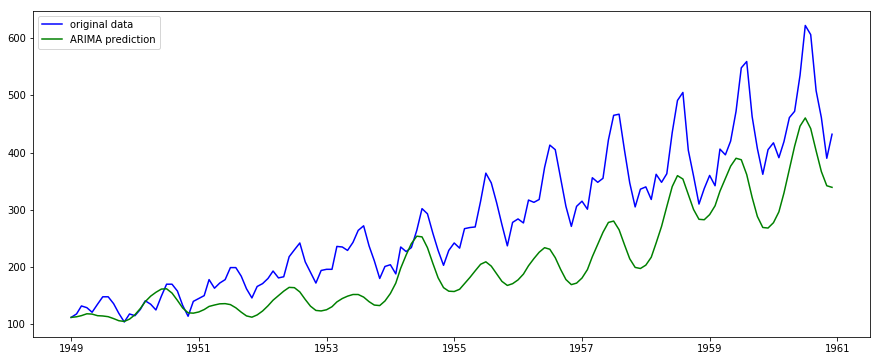

In [134]:
plt.plot(ts,color='blue',label='original data')
plt.plot(predictions_ARIMA,color='green',label='ARIMA prediction')
plt.legend()

In [156]:
arr  = np.array([[[1,2,3],[4,5,6]],[[7,8,9],[6,6,6]]])
print(arr)
print(arr.cumsum(0))  #cumsum是维度0的cumsum
print(arr.cumsum(1))   #cumsum是维度1的cumsum
print(arr.cumsum(2))   #cumsum是维度2的cumsum

[[[1 2 3]
  [4 5 6]]

 [[7 8 9]
  [6 6 6]]]
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 8 10 12]
  [10 11 12]]]
[[[ 1  2  3]
  [ 5  7  9]]

 [[ 7  8  9]
  [13 14 15]]]
[[[ 1  3  6]
  [ 4  9 15]]

 [[ 7 15 24]
  [ 6 12 18]]]
